<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

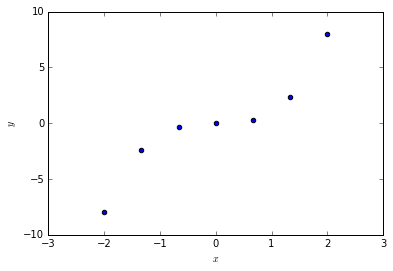

In [83]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

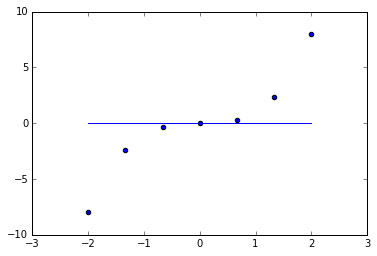

In [84]:
plt.scatter(X, y)
plt.plot(X, [y.mean() for _ in X])

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def regression_var_criterion(X, y, t):


**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7 +
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [8]:
df = pd.read_csv('mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [9]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [10]:
df['age_years'] = (df['age'] // 365.25).astype(int)

In [11]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
id,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47


In [13]:
df.drop(['cholesterol', 'gluc'], axis=1)

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50,1.0,0.0,0.0,1.0,0.0,0.0
1,20228,1,156,85.0,140,90,0,0,1,1,55,0.0,0.0,1.0,1.0,0.0,0.0
2,18857,1,165,64.0,130,70,0,0,0,1,51,0.0,0.0,1.0,1.0,0.0,0.0
3,17623,2,169,82.0,150,100,0,0,1,1,48,1.0,0.0,0.0,1.0,0.0,0.0
4,17474,1,156,56.0,100,60,0,0,0,0,47,1.0,0.0,0.0,1.0,0.0,0.0
8,21914,1,151,67.0,120,80,0,0,0,0,59,0.0,1.0,0.0,0.0,1.0,0.0
9,22113,1,157,93.0,130,80,0,0,1,0,60,0.0,0.0,1.0,1.0,0.0,0.0
12,22584,2,178,95.0,130,90,0,0,1,1,61,0.0,0.0,1.0,0.0,0.0,1.0
13,17668,1,158,71.0,110,70,0,0,1,0,48,1.0,0.0,0.0,1.0,0.0,0.0


In [99]:
y = df['cardio']
x = df.drop('cardio', axis=1)

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=17)

In [16]:
X_train

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,,
30908,18243,2,169,76.0,160,80,1,1,0,0,1,49,1.0,0.0,0.0,1.0,0.0,0.0
86475,17445,2,158,68.0,140,90,1,1,1,0,1,47,1.0,0.0,0.0,1.0,0.0,0.0
77291,22645,1,165,70.0,120,80,1,2,0,0,1,61,1.0,0.0,0.0,0.0,1.0,0.0
63162,16778,1,140,70.0,140,90,1,1,0,0,0,45,1.0,0.0,0.0,1.0,0.0,0.0
43647,17606,2,172,101.0,120,80,1,1,0,0,0,48,1.0,0.0,0.0,1.0,0.0,0.0
43357,20453,1,165,74.0,100,70,1,1,0,0,0,55,1.0,0.0,0.0,1.0,0.0,0.0
8204,20591,1,150,53.0,120,80,1,1,0,0,1,56,1.0,0.0,0.0,1.0,0.0,0.0
32488,20470,1,165,65.0,120,80,1,1,0,0,0,56,1.0,0.0,0.0,1.0,0.0,0.0
47958,16240,2,167,85.0,120,80,1,1,0,0,1,44,1.0,0.0,0.0,1.0,0.0,0.0


Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [17]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [18]:
from sklearn.tree import export_graphviz
export_graphviz(tree, feature_names = x.columns, 
out_file='small_tree.dot', filled=True)

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3+

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [19]:
predicted = tree.predict(X_valid)
accuracy = accuracy_score(y_valid, predicted)
accuracy

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [20]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv=5)


In [21]:
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

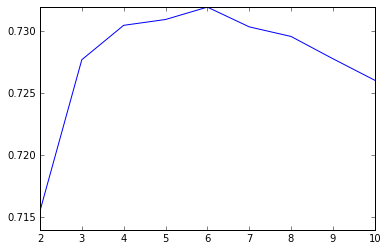

In [22]:
plt.plot(tree_grid.param_grid['max_depth'], tree_grid.cv_results_['mean_test_score']);

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [23]:
tree_grid.best_params_

{'max_depth': 6}

In [24]:
accuracy_score(y_valid, tree_grid.predict(X_valid))

0.72585714285714287

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет +
- нет, да
- нет, нет

In [25]:
(accuracy_score(y_valid, tree_grid.predict(X_valid))-accuracy)/accuracy*100

0.63378886908298504

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский 
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)+
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [63]:
temp = df[['smoke', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3']]

In [64]:

temp.head()

,smoke,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,
0,0,1.0,0.0,0.0
1,0,0.0,0.0,1.0
2,0,0.0,0.0,1.0
3,0,1.0,0.0,0.0
4,0,1.0,0.0,0.0


In [66]:
temp['ap_hi1'] = df['ap_hi'].apply(lambda i: 1 if 120 <= i < 140 else 0)
temp['ap_hi2'] = df['ap_hi'].apply(lambda i: 1 if 140 <= i < 160 else 0)
temp['ap_hi3'] = df['ap_hi'].apply(lambda i: 1 if 160 <= i < 180 else 0)

temp['age1'] = df['age_years'].apply(lambda i: 1 if 45 <= i < 50 else 0)
temp['age2'] = df['age_years'].apply(lambda i: 1 if 50 <= i < 55 else 0)
temp['age3'] = df['age_years'].apply(lambda i: 1 if 55 <= i < 60 else 0)
temp['age4'] = df['age_years'].apply(lambda i: 1 if 60 <= i < 65 else 0)



In [67]:
temp['gender'] = df.gender.map({1:0, 2:1})

In [68]:
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=17)

In [69]:
y = df['cardio']
decision_tree.fit(temp,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [70]:
temp.columns

Index(['smoke', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3', 'ap_hi1',
       'ap_hi2', 'ap_hi3', 'age1', 'age2', 'age3', 'age4', 'gender'],
      dtype='object')

In [71]:
export_graphviz(decision_tree, feature_names=list(temp.columns), 
                out_file='tree1.dot', filled=True)